# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data1 = pd.read_csv('/datasets/geo_data_0.csv')
data2 = pd.read_csv('/datasets/geo_data_1.csv')
data3 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим наши датафреймы

# Первый регион

In [3]:
data1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data1.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущеных данных нет

In [6]:
data1.duplicated().sum()

0

Явных дубликатов в таблице не наблюдается

# Второй регион

In [7]:
data2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data2.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущеных данных нет

In [10]:
data2.duplicated().sum()

0

Явных дубликатов в таблице не наблюдается

# Третий регион

In [11]:
data3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
data3.isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущеных данных нет

In [13]:
data3.duplicated().sum()

0

Явных дубликатов в таблице не наблюдается

Так как далее мы будем делать один и тот же процесс с каждым регионом, создадим список датасетов, чтобы ускорить работу

In [14]:
data=[data1,data2,data3]

Cтолбец id (id- уникальный идентификатор скважины) в каждой таблице никак не повлияет на ход нашего решения, поэтому можем избавиться от него

In [15]:
for i in range(len(data)):
    data[i] = data[i].drop(['id'], axis=1)
    display(data[i].head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [16]:
data1.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Есть несколько повторений id, но признаки у них разные, возможно проводились какие-то измерения трех других точек в этих же скважинах

In [17]:
data2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id почти у всех разные, но значений product всего 12, это никакая не ошибка, видимо, алгоритм измерения приходит к таким значениям, что в жизни, наверное, маловероятно

In [18]:
data3.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Аналогично с первым датасетом

Оставляем эти данные

Рассмотрим распределение нефти от региона к региону 

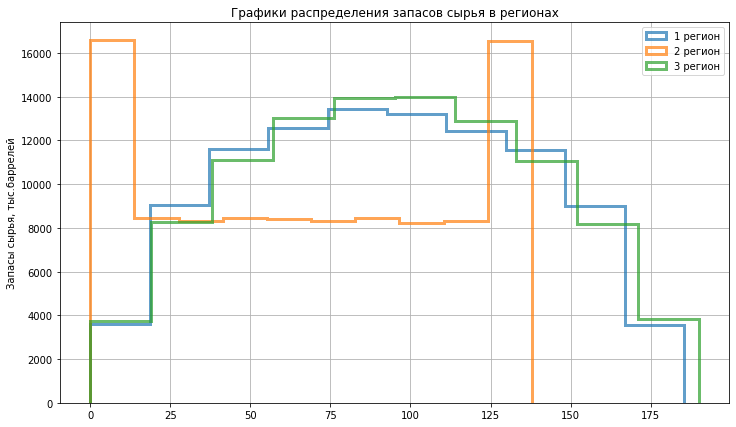

In [19]:
plt.title('Графики распределения запасов сырья в регионах')
f=data1['product'].plot(kind='hist',figsize=(12,5),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=3, label='1 регион')
f1=data2['product'].plot(kind='hist',figsize=(12,5),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='2 регион', ax=f)
data3['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=3, label='3 регион', ax=f1)
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

У региона 2 график запасов значительно отличается, от других регионов. Вероятно, это приведет к тому что значение среднего запаса нефти во 2 регионе, будет отличаться от 1 и 3, а у этих регионов средний запас будет похож

In [20]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [21]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [22]:
data3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Интересно, что во 2 регионе видим сильную зависимость между profit от f2, это приведет к тому что наша модель будет давать гораздо более точные ответы

## Обучение и проверка модели

Напишем общую функцию для обучения моделей


In [23]:
predictions=[]
answers=[]
for i in range(len(data)):
    features = data[i].drop(["product"], axis=1)
    target = data[i]["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)

    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(predicted_valid, target_valid))**(0.5)
    predictions.append(predicted_valid)
    answers.append(target_valid.reset_index(drop=True))
    print('rmse',i+1,'регионa', rmse)
    print('средний запас', i+1 ,'региона',predicted_valid.mean())
    print('реальный запас', i+1 ,'региона',target_valid.mean())   

rmse 1 регионa 37.5794217150813
средний запас 1 региона 92.59256778438035
реальный запас 1 региона 92.07859674082927
rmse 2 регионa 0.893099286775617
средний запас 2 региона 68.728546895446
реальный запас 2 региона 68.72313602435997
rmse 3 регионa 40.02970873393434
средний запас 3 региона 94.96504596800489
реальный запас 3 региона 94.88423280885438


cохраним ответы и предсказания

**Вывод**

Из полученных результатов RMSE 2 региона гораздо ниже, чем в двух других, при этом именно во втором регионе самые низкие запасы предсказанного сырья

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчетов

In [24]:
number_points=500
best_points=200
budget=10**10
cost=450000

Рассчитаеи достаточный объём сырья для безубыточной разработки новой скважины

In [25]:
v=budget/cost
v

22222.222222222223

то есть нужно добывать минимум 22222 тысячи бареллей чтобы выйти в ноль

Чтобы этого достичь в скважине дожно находиться в среднем:

In [26]:
v/best_points

111.11111111111111

111 тысяч бареллей нефти в одной скважине в среднем

В среднем в каждом регионе в одной скважине в среднем меньше чем необходимое нам значение, именно поэтому нужно выбрать 200 лучших скважин, чтобы получать прибыль

**Напишем функцию расчета прибыли**

In [27]:
def calc_profit(answers, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    answer_selected = answers[predictions_sorted.index][:200]

    return answer_selected.sum() * cost - budget


for i  in range(3):
    predictions_sample = pd.Series(predictions[i])      
    
    profit = calc_profit(answers[i], predictions_sample)
    print('Регион',i+1,'=',profit/(10**9),'млрд')
    

Регион 1 = 3.3208260431398506 млрд
Регион 2 = 2.4150866966815108 млрд
Регион 3 = 2.7103499635998327 млрд


## Расчёт прибыли и рисков 

In [28]:
state = np.random.RandomState(12345)  

In [29]:
result = pd.DataFrame(
            columns=['Регион',
            'Средняя прибыль, млн.', 
            '95%-й доверительный интервал, млн.', 
            'Риск убытков, %']
)

for v in range(3):
    prediction = predictions[v]
    target = answers[v]
    profit_values = []
    for i in range(1000):
        prediction_series = pd.Series(prediction)
        predictions_sample  = prediction_series.sample(500, replace=True, random_state=state)
        target_sample = target[predictions_sample.index]
        predictions_sample = predictions_sample.reset_index(drop = True)
        target_sample = pd.Series(target_sample)
        target_sample = target_sample.reset_index(drop = True)
              
        profit_values.append(calc_profit(target_sample, predictions_sample))
 
    profit_values = pd.Series(profit_values)
    mean_profit = round(profit_values.mean()/1000000)
    confidence_interval = (f'{profit_values.quantile(0.05)/1000000:.0f} ... ' 
                           f'{profit_values.quantile(0.95)/1000000:.0f}') 
    risks = round((profit_values < 0).mean()*100, 1)   
   
    result.loc[len(result)] = [v+1, mean_profit, confidence_interval, risks]

display(result)


,Регион,"Средняя прибыль, млн.","95%-й доверительный интервал, млн.","Риск убытков, %"
0,1,396,-37 ... 843,6.9
1,2,461,140 ... 808,0.7
2,3,393,-28 ... 841,6.5


# Вывод

Наиболее перспективным для разработки представляется регион 2, поскольку риски убытков наименьшие, а именно меньше 1,5%, что гораздо  меньше рисков в двух других регионах. Также в этом регионе наибольшая средняя прибыль. Так что 2 регион самый выгодный